# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 01.06.2025**

**Мягкий дедлайн: 14.06.2025 23:59 MSK**

**Жёсткий дедлайн: 16.06.2025 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


![photo_2023-05-17%2020.06.18.jpeg](attachment:photo_2023-05-17%2020.06.18.jpeg)

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def apk(relevant: List[int], predicted: List[int], k: int = 20):

    predicted_k = predicted[:k]
    score = 0
    true_obj = 0

    for ind, p in enumerate(predicted_k):
        if p in relevant:
            true_obj += 1
            precision_at_i = true_obj / (ind + 1)
            score += precision_at_i

    return score / min(len(relevant), k)

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    return sum(apk(rel, pred, k) for rel, pred in zip(relevant, predicted)) / len(relevant)

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        for user_id in range(self.n_users):
            preds = self.recommend(user_id)
            test_preds.append(preds)

        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [15]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    numerator = ratings@user_vector.T
    denominator = np.sum(ratings+user_vector!=0,1)

    scores = np.divide(numerator, denominator)
    scores[scores == 1] = -1
    return scores

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [16]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        scores = np.asarray(self.similarity_func(self.R,user_vector)).squeeze()

        mask = scores>self.alpha
        scores = scores[mask]

        numerator = scores @ self.R[mask]
        denominator = np.sum(scores)

        return numerator/denominator

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)

        return np.argsort(similarities)[::-1]

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [17]:
from random import sample

<ipython-input-16-422171738>:21: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


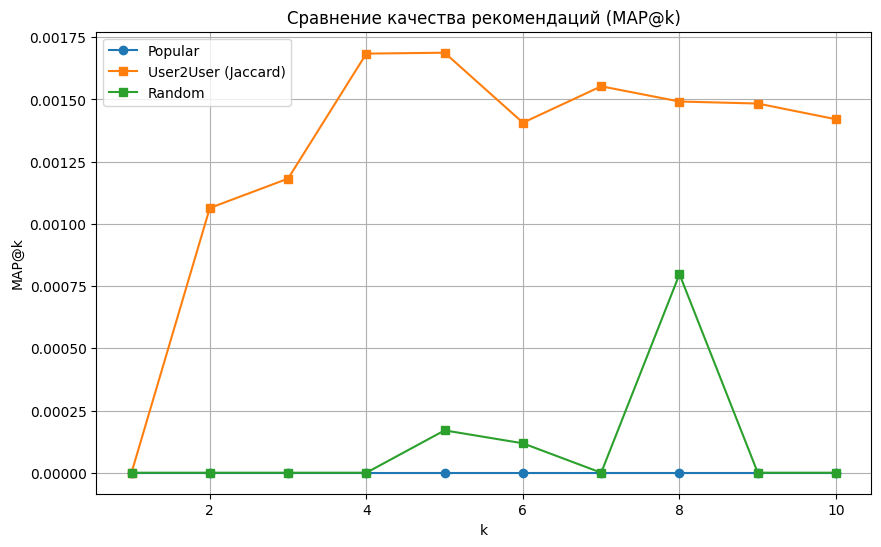

In [18]:
k_values = [1,2,3,4, 5,6,7,8,9, 10]

map_popular = []
map_jaccard = []
map_random = []

track_popularity = train_ratings.sum(axis=0).sort_values(ascending=False)
most_popular_tracks = track_popularity.index.tolist()

model_jaccard = User2User(train_ratings)

N = model_jaccard.n_users
all_items = list(range(model_jaccard.n_items))

for k in k_values:

    recomends_popular = [most_popular_tracks[:max(k_values)] for _ in range(len(test_ratings))]

    recomends_jaccard = model_jaccard.get_test_recommendations(k)

    recomends_random = []
    for _ in range(N):
        recomends_random.append(sample(all_items, k))

    map_p = mapk(test_relevant, recomends_popular, k)
    map_j = mapk(test_relevant, recomends_jaccard, k)
    map_r = mapk(test_relevant, recomends_random, k)

    map_popular.append(map_p)
    map_jaccard.append(map_j)
    map_random.append(map_r)

plt.figure(figsize=(10, 6))
plt.plot(k_values, map_popular, marker='o', label='Popular')
plt.plot(k_values, map_jaccard, marker='s', label='User2User (Jaccard)')
plt.plot(k_values, map_random, marker='s', label='Random')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k)')
plt.legend()
plt.grid(True)
plt.show()

User2User оказался самым лучшим методом (странно было бы, если бы это было не так)

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [19]:
from scipy.sparse import csr_matrix
import time

In [20]:
start = time.time()
model_dense = User2User(train_ratings)
model_dense.get_test_recommendations(k=20)
print("Base time:", time.time() - start)

<ipython-input-16-422171738>:21: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Base time: 26.317043781280518


In [21]:
class User2User_Sparse(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02
        self.R = csr_matrix(self.R)

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        user_vector = user_vector.toarray()
        # print(self.R.shape)
        # print(user_vector.shape)
        scores = np.asarray(self.similarity_func(self.R,user_vector)).squeeze()

        mask = scores>self.alpha
        scores = scores[mask]

        numerator = scores @ self.R[mask]
        denominator = np.sum(scores)

        return numerator/denominator

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)

        return np.argsort(similarities)[::-1]

In [22]:
start = time.time()
model = User2User_Sparse(train_ratings)
model.get_test_recommendations(k=20)
print("Sparse time:", time.time() - start)

<ipython-input-21-4233907261>:25: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Sparse time: 17.103631019592285


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [23]:
user_id = np.random.randint(0, model.n_users)

In [24]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
6,Meet Me Halfway,['Black Eyed Peas']
7,I Gotta Feeling,['Black Eyed Peas']
62,War,['Edwin Starr']
69,Cry For You,['September']
74,Stronger,['Kanye West']
97,Heads Will Roll,['Yeah Yeah Yeahs']
100,Heartbreaker,['will.i.am']
101,Let It Rock,"['Kevin Rudolf', 'Lil Wayne']"
102,Just Dance,"['Lady Gaga', ""Colby O'Donis""]"
109,Rehab,['Rihanna']


In [25]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

<ipython-input-21-4233907261>:25: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Predicted tracks:


,name,artists
22447,Falls of Glory,['BrunuhVille']
22446,The Wolf and the Moon,['BrunuhVille']
22445,Richter: On the Nature of Daylight,"['Max Richter Orchestra', 'Lorenz Dangel']"
22444,The Way I Am,['Eminem']
22443,Richter: Infra 5,"['Max Richter', 'Louisa Fuller', 'Natalia Bonn..."
22442,Mosquito Song,['Queens of the Stone Age']
22441,Gonna Leave You,['Queens of the Stone Age']
22440,First It Giveth,['Queens of the Stone Age']
22439,Hurt (Quiet),['Nine Inch Nails']
22438,Richter: Sunlight,"['Louisa Fuller', 'Natalia Bonner', 'Rico Cost..."


In [26]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
62053,Ritual,['Sibewest']
62278,IDWK,"['Remady', 'Manu-L']"
63370,Some Love,"['Tim Dian', 'ladynsax']"
63474,Even If You Don't,['Lulleaux']
63981,Get Lucky,['Jack Koden']
64056,Ya Lame,['Demeter']
65756,Fire In My Head,['Two Feet']
65816,Jalebi Baby,"['Dj Viral TikToker', 'Dj Viral Social Challen..."
65979,Time Warp,"['Apashe', 'Sami Chaouki']"
66744,Cold Heart,"['Elton John', 'Dua Lipa', 'PNAU']"


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:** В данном методе просто идём по градиенту функций для каждого вектора

Обновление $p_{uk}$: $$p_{uk} = p_{uk} + \eta q_{ik}(r_{ui} - \langle p_u, q_i \rangle)-\eta\lambda p_{uk}$$
Обнолвение $q_{ik}$: $$p_{uk} = q_{ik} + \eta p_{uk}(r_{ui} - \langle p_u, q_i \rangle)-\eta\lambda q_{ik}$$


**ALS:**  По очереди фиксируем P и Q, тогда функционал будет выпуклым, и по нему ищем оптимальные параметры

Обновление $p_{u}$: $$p_{u} = (\sum_{i: ∃r_{ui}} (\langle q_i, q_i \rangle + λ))^{-1}\sum_{i: ∃r_{ui}} (r_{ui}q_i)$$

Обнолвение $q_{i}$: $$q_{i} = (\sum_{u: ∃r_{ui}} (\langle p_u, p_u \rangle + λ))^{-1}\sum_{u: ∃r_{ui}} (r_{ui}p_u)$$



**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [27]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

        # self.R = csr_matrix(self.R)

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                rows, cols = self.R.nonzero()
                for u, i in zip(rows, cols):
                    r_ui = self.R[u, i]

                    pred = self.P[u] @ self.Q[i]
                    err = r_ui - pred

                    self.P[u] += self.lr * (err * self.Q[i] - self.lamb * self.P[u])
                    self.Q[i] += self.lr * (err * self.P[u] - self.lamb * self.Q[i])

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                # R = self.R.tocsr()
                R = self.R

                for u in range(self.n_users):
                    # item_ids = R[u].indices

                    item_ids = np.where(R[u] != 0)[0]
                    if len(item_ids) == 0:
                        continue

                    Q_i = self.Q[item_ids]
                    # r_u = R[u, item_ids].toarray().flatten()
                    r_u = R[u, item_ids]

                    A = Q_i.T @ Q_i + self.lamb * np.eye(self.dim)
                    b = Q_i.T @ r_u
                    self.P[u] = np.linalg.solve(A, b) # типо вместо поиска обратной матрицы

                # R_T = self.R.T.tocsr()
                R_T = self.R.T

                for i in range(self.n_items):
                    # user_ids = R_T[i].indices
                    user_ids = np.where(R_T[i] != 0)[0]
                    if len(user_ids) == 0:
                        continue

                    P_u = self.P[user_ids]
                    # r_i = R_T[i, user_ids].toarray().flatten()
                    r_i = R_T[i, user_ids]

                    A = P_u.T @ P_u + self.lamb * np.eye(self.dim)
                    b = P_u.T @ r_i
                    self.Q[i] = np.linalg.solve(A, b)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

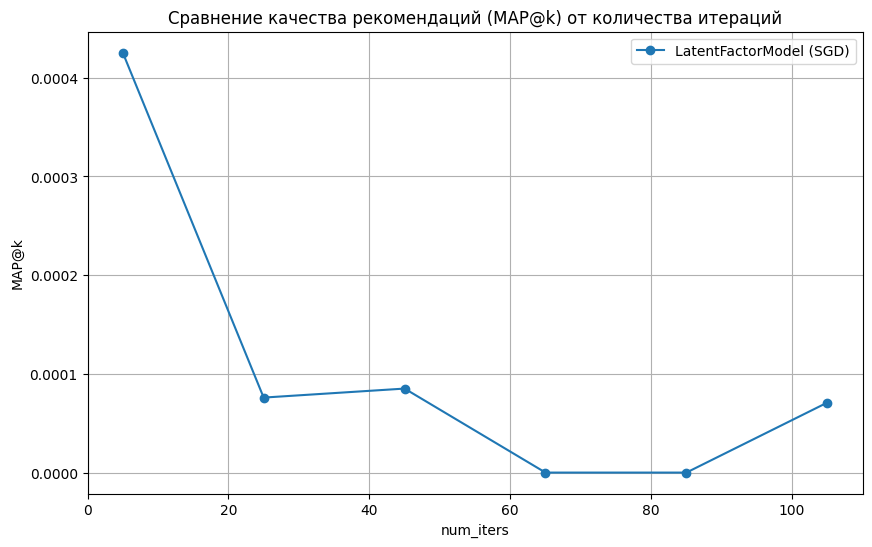

In [28]:
num_iters_values = np.arange(5, 106, 20)
dim = 64
k = 10

map_sgd = []

for num_iters in num_iters_values:
    model_sgd = LatentFactorModel(train_ratings, dim, 'sgd')

    model_sgd.fit(num_iters=num_iters)

    recomends_sgd = model_sgd.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, recomends_sgd, k)

    map_sgd.append(mapk_sgd)

plt.figure(figsize=(10, 6))
plt.plot(num_iters_values, map_sgd, marker='o', label='LatentFactorModel (SGD)')

plt.xlabel('num_iters')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k) от количества итераций')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

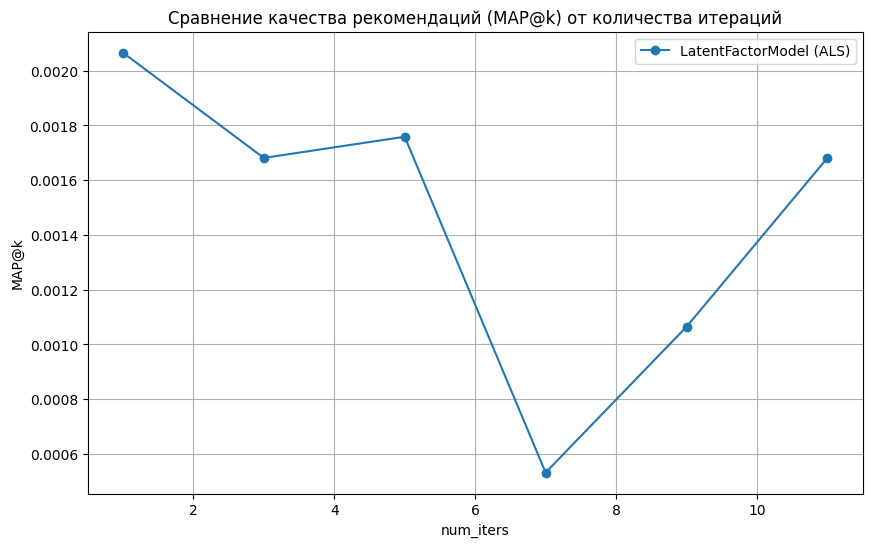

In [29]:
num_iters_values = np.arange(1, 12, 2)
dim = 64
k = 10

map_als = []

for num_iters in num_iters_values:
    model_als = LatentFactorModel(train_ratings, dim, 'als')

    model_als.fit(num_iters=num_iters)

    recomends_als = model_als.get_test_recommendations(k)

    mapk_als = mapk(test_relevant, recomends_als, k)

    map_als.append(mapk_als)

plt.figure(figsize=(10, 6))
plt.plot(num_iters_values, map_als, marker='o', label='LatentFactorModel (ALS)')

plt.xlabel('num_iters')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k) от количества итераций')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

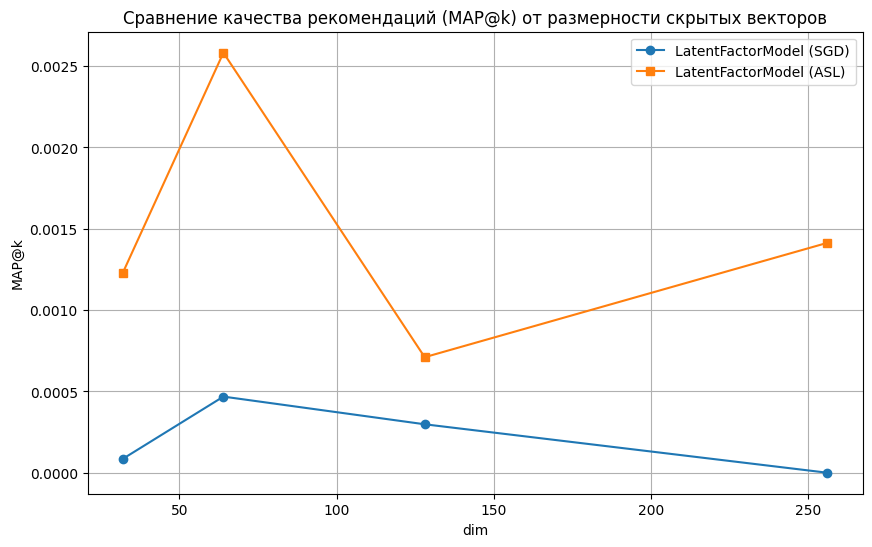

In [30]:
dim_values = [32,64,128,256]

k = 10

map_sgd = []
map_asl = []

for dim in dim_values:
    model_sgd = LatentFactorModel(train_ratings, dim, 'sgd')
    model_asl = LatentFactorModel(train_ratings, dim, 'als')

    model_sgd.fit(num_iters=85)
    model_asl.fit(num_iters=7)

    recomends_sgd = model_sgd.get_test_recommendations(k)
    recomends_asl = model_asl.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, recomends_sgd, k)
    mapk_asl = mapk(test_relevant, recomends_asl, k)

    map_sgd.append(mapk_sgd)
    map_asl.append(mapk_asl)

plt.figure(figsize=(10, 6))
plt.plot(dim_values, map_sgd, marker='o', label='LatentFactorModel (SGD)')
plt.plot(dim_values, map_asl, marker='s', label='LatentFactorModel (ASL)')

plt.xlabel('dim')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k) от размерности скрытых векторов')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


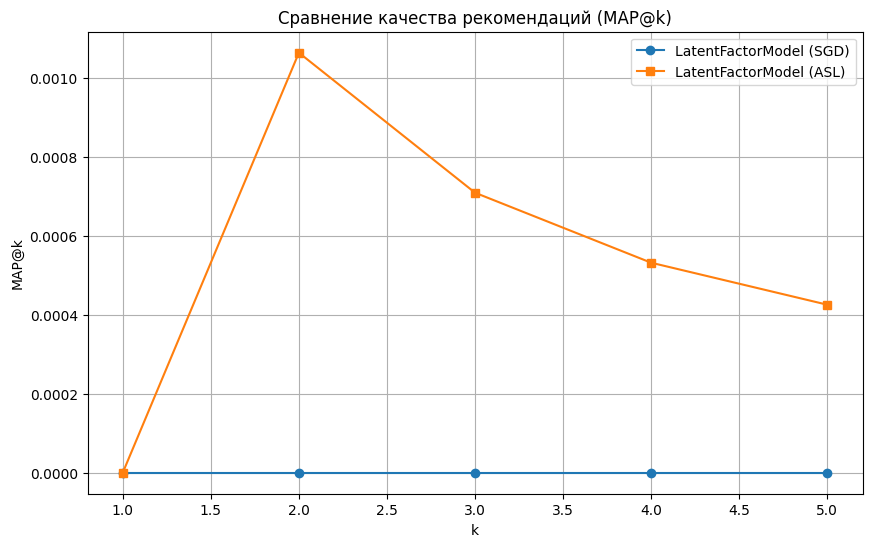

In [33]:
dim = 128
k_values = [1,2,3,4,5]

map_sgd = []
map_asl = []

model_sgd = LatentFactorModel(train_ratings, dim, 'sgd')
model_asl = LatentFactorModel(train_ratings, dim, 'als')

model_sgd.fit(num_iters=85)
model_asl.fit(num_iters=7)

for k in k_values:

    recomends_sgd = model_sgd.get_test_recommendations(k)
    recomends_asl = model_asl.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, recomends_sgd, k)
    mapk_asl = mapk(test_relevant, recomends_asl, k)

    map_sgd.append(mapk_sgd)
    map_asl.append(mapk_asl)

plt.figure(figsize=(10, 6))
plt.plot(k_values, map_sgd, marker='o', label='LatentFactorModel (SGD)')
plt.plot(k_values, map_asl, marker='s', label='LatentFactorModel (ASL)')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('Сравнение качества рекомендаций (MAP@k)')
plt.legend()
plt.grid(True)
plt.show()

В дальнейшем будет использоваться алгоритм ALS, так как он просто показал себя лучше.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [34]:
model = model_asl

In [35]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [36]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.720776
5570,Моё сердце,['Сплин'],0.605639
16637,Zodiac,['Zodiac'],0.599017
9689,Bicycle Race,['Queen'],0.599017
5153,Stormbringer,['Deep Purple'],0.599017
17331,"Последнее письмо (Гудбай, Америка)",['Nautilus Pompilius'],0.587069
5517,Варвара,['Би-2'],0.584426
26075,Лошадка,['Найк Борзов'],0.569835
2179,Восьмиклассница,['КИНО'],0.566921


**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [37]:
class iALSModel(LatentFactorModel):
    def __init__(self, ratings, dim=128, alpha=40, lamb=0.01):
        super().__init__(ratings, dim, mode='als')
        self.alpha = alpha
        self.lamb = lamb
        self.binary_R = (self.R > 0).astype(np.float32)

    def fit(self, num_iters=5):
        C = 1 + self.alpha * self.binary_R

        for epoch in tqdm(range(num_iters), desc="iALS"):
            for u in range(self.n_users):
                item_ids = np.where(self.binary_R[u] != 0)[0]
                if len(item_ids) == 0:
                    continue

                Cu = np.diag(C[u, item_ids])
                Q_i = self.Q[item_ids]
                YTY = Q_i.T @ Cu @ Q_i
                A = YTY + self.lamb * np.eye(self.dim)
                b = Q_i.T @ Cu @ np.ones(len(item_ids))
                self.P[u] = np.linalg.solve(A, b)

            for i in range(self.n_items):
                user_ids = np.where(self.binary_R[:, i] != 0)[0]
                if len(user_ids) == 0:
                    continue

                Ci = np.diag(C[user_ids, i])
                P_u = self.P[user_ids]
                XTX = P_u.T @ Ci @ P_u
                A = XTX + self.lamb * np.eye(self.dim)
                b = P_u.T @ Ci @ np.ones(len(user_ids))
                self.Q[i] = np.linalg.solve(A, b)

In [38]:
k_values = [1,2,3,4,5,6,7,8,9,10]

dim = 128

model_ials = iALSModel(train_ratings, dim=dim)
model_ials.fit(num_iters=7)

for k in k_values:
    recomends_iasl = model_ials.get_test_recommendations(k)

    mapk_iasl = mapk(test_relevant, recomends_iasl, k)
    print(f'MAP@{k} with IALS: {mapk_iasl}')

iALS:   0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


MAP@1 with IALS: 0.0
MAP@2 with IALS: 0.0010638297872340426
MAP@3 with IALS: 0.0016548463356973995
MAP@4 with IALS: 0.00150709219858156
MAP@5 with IALS: 0.0012056737588652482
MAP@6 with IALS: 0.0010047281323877068
MAP@7 with IALS: 0.0008611955420466059
MAP@8 with IALS: 0.00075354609929078
MAP@9 with IALS: 0.0008274231678486997
MAP@10 with IALS: 0.0007446808510638297


### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [39]:
from collections import defaultdict

In [40]:
model_lfm = LatentFactorModel(train_ratings, dim=128, mode='als')
model_lfm.fit(num_iters=7)

model_u2u = User2User(train_ratings)

  0%|          | 0/7 [00:00<?, ?it/s]

In [41]:
lfm_candidates = model_lfm.get_test_recommendations(100)
u2u_candidates = model_u2u.get_test_recommendations(100)

<ipython-input-14-4139095649>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
<ipython-input-16-422171738>:21: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator


In [42]:
all_recomends = lfm_candidates | u2u_candidates

In [43]:
test_users_all = test_ratings['userId'].unique()

candidate_pairs = []

for idx, (lfm_rec, u2u_rec) in enumerate(zip(lfm_candidates, u2u_candidates)):
    user_id = test_users_all[idx]
    for track_id in set(list(lfm_rec) + list(u2u_rec)):
        candidate_pairs.append((user_id, track_id))

all_recomends_df = pd.DataFrame(candidate_pairs, columns=['userId', 'trackId'])

In [44]:
all_recomends_df

,userId,trackId
0,0,27650
1,0,14853
2,0,17926
3,0,41479
4,0,1034
...,...,...
43741,240,39923
43742,240,27126
43743,240,1019
43744,240,46077


**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()

In [46]:
n_users = train_ratings["userId"].nunique()

track_popularity = (
    train_ratings.groupby("trackId")["userId"]
    .nunique()
    .div(n_users)
    .to_dict()
)

user_activity = (
    train_ratings.groupby("userId")["trackId"]
    .count()
    .to_dict()
)

In [47]:
last_50_dict = (
    test_ratings
    .groupby("userId")["trackId"]
    .apply(lambda x: set(x.tail(50)))
    .to_dict()
)

In [48]:
def extract_features(df, model_lfm, model_u2u, last_50_dict,
                     track_popularity, user_activity):
    P, Q = model_lfm.P, model_lfm.Q

    def row_features(row):
        u, i = row["userId"], row["trackId"]

        cos_sim = cosine_similarity(P[u].reshape(1, -1), Q[i].reshape(1, -1))[0, 0]

        sim_vec = model_u2u.R[u]
        mean_jac = sim_vec.mean()

        pop = track_popularity.get(i, 0.0)

        act = user_activity.get(u, 0)

        label = int(i in last_50_dict.get(u, set()))

        return pd.Series([cos_sim, mean_jac, pop, act, label])
        # return pd.Series([cos_sim, mean_jac, pop, act])

    df[["cos_sim_lfm", "mean_jaccard_u2u", "track_popularity",
        "user_activity", "label"]] = df.progress_apply(row_features, axis=1)
    # df[["cos_sim_lfm", "mean_jaccard_u2u", "track_popularity",
    #     "user_activity"]] = df.progress_apply(row_features, axis=1)

    return df

In [49]:
lfm_features = extract_features(
    # train_ratings.copy(),
    all_recomends_df.copy(),
    model_lfm,
    model_u2u,
    last_50_dict,
    track_popularity,
    user_activity,
)
lfm_features

100%|██████████| 43746/43746 [00:36<00:00, 1210.93it/s]


,userId,trackId,cos_sim_lfm,mean_jaccard_u2u,track_popularity,user_activity,label
0,0,27650,0.203816,0.00306,0.041494,206.0,0.0
1,0,14853,0.101438,0.00306,0.012448,206.0,0.0
2,0,17926,-0.044793,0.00306,0.045643,206.0,0.0
3,0,41479,0.279501,0.00306,0.033195,206.0,0.0
4,0,1034,-0.095392,0.00306,0.008299,206.0,0.0
...,...,...,...,...,...,...,...
43741,240,39923,0.035889,0.02478,0.091286,1668.0,0.0
43742,240,27126,0.108409,0.02478,0.053942,1668.0,0.0
43743,240,1019,0.067399,0.02478,0.199170,1668.0,0.0
43744,240,46077,0.046952,0.02478,0.012448,1668.0,0.0


In [50]:
lfm_features['label'].value_counts()

,count
label,
0.0,43559
1.0,187


In [51]:
X = lfm_features.drop('label', axis=1)
X

,userId,trackId,cos_sim_lfm,mean_jaccard_u2u,track_popularity,user_activity
0,0,27650,0.203816,0.00306,0.041494,206.0
1,0,14853,0.101438,0.00306,0.012448,206.0
2,0,17926,-0.044793,0.00306,0.045643,206.0
3,0,41479,0.279501,0.00306,0.033195,206.0
4,0,1034,-0.095392,0.00306,0.008299,206.0
...,...,...,...,...,...,...
43741,240,39923,0.035889,0.02478,0.091286,1668.0
43742,240,27126,0.108409,0.02478,0.053942,1668.0
43743,240,1019,0.067399,0.02478,0.199170,1668.0
43744,240,46077,0.046952,0.02478,0.012448,1668.0


In [52]:
y = lfm_features['label']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=52)

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [54]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00


In [55]:
sort_id = np.argsort(X_train['userId'])
X_train = X_train.iloc[sort_id].reset_index(drop=True)
y_train = y_train.iloc[sort_id].reset_index(drop=True)

sort_id = np.argsort(X_test['userId'])
X_test = X_test.iloc[sort_id].reset_index(drop=True)
y_test = y_test.iloc[sort_id].reset_index(drop=True)

In [56]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=X_train['userId'])
test_pool = catboost.Pool(X_test, y_test, group_id=X_test['userId'])

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [57]:
from catboost import CatBoostClassifier

catboostclass = CatBoostClassifier(
    iterations=1000,
    verbose=0,
    random_seed=52
)

catboostclass.fit(train_pool)

In [58]:
preds_catboost = []

for user_id, user_data in X_test.groupby('userId'):
    probs = catboostclass.predict_proba(user_data)[:, 1]

    user_data['pred_prob'] = probs
    top_tracks = user_data.sort_values('pred_prob', ascending=False)['trackId'].tolist()

    preds_catboost.append(top_tracks)

lfm_pred_df = pd.DataFrame([
    {'userId': user_id, 'preds': pred}
    for user_id, pred in zip(test_users_all, lfm_candidates)
])

u2u_pred_df = pd.DataFrame([
    {'userId': user_id, 'preds': pred}
    for user_id, pred in zip(test_users_all, u2u_candidates)
])

lfm_pred_df = lfm_pred_df[lfm_pred_df['userId'].isin(X_test['userId'].unique())].reset_index(drop=True)
u2u_pred_df = u2u_pred_df[u2u_pred_df['userId'].isin(X_test['userId'].unique())].reset_index(drop=True)

ground_truth = (ratings.groupby('userId')['trackId'].apply(list).to_dict())

test_relevant_new = [ground_truth.get(user_id, []) for user_id in lfm_pred_df['userId']]

lfm_preds = lfm_pred_df['preds'].tolist()
u2u_preds = u2u_pred_df['preds'].tolist()

In [59]:
map20_catboostclass = mapk(test_relevant_new, preds_catboost, k=20)
map20_lfm = mapk(test_relevant_new, lfm_preds, k=20)
map20_u2u = mapk(test_relevant_new, u2u_preds, k=20)

In [60]:
print(f'MAP@20 (CatBoostClassifier): {map20_catboostclass:.4f}')
print(f'MAP@20 (LFM): {map20_lfm:.4f}')
print(f'MAP@20 (User2User): {map20_u2u:.4f}')

MAP@20 (CatBoostClassifier): 0.0017
MAP@20 (LFM): 0.0015
MAP@20 (User2User): 0.0017


Ну это вообще кошмар какой-то, я уже не знаю. По ощущениям признаки от плохих моделей просто испортили результат катбуста.

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [61]:
from catboost import CatBoostRanker
from sklearn.metrics import ndcg_score

In [62]:
ranker = CatBoostRanker(
    iterations=1000,
    eval_metric='MAP:top=20',
    verbose=100,
    random_seed=52
)

ranker.fit(train_pool, eval_set=test_pool)

0:	learn: 0.0378309	test: 0.0299363	best: 0.0299363 (0)	total: 61.7ms	remaining: 1m 1s
100:	learn: 0.1930918	test: 0.0594720	best: 0.0625231 (88)	total: 7.08s	remaining: 1m 3s
200:	learn: 0.2270060	test: 0.0667307	best: 0.0714276 (172)	total: 12.6s	remaining: 50.2s
300:	learn: 0.2612386	test: 0.0687353	best: 0.0716090 (256)	total: 19.3s	remaining: 44.9s
400:	learn: 0.2664235	test: 0.0678292	best: 0.0716090 (256)	total: 25.2s	remaining: 37.6s
500:	learn: 0.2726950	test: 0.0666179	best: 0.0716090 (256)	total: 31.6s	remaining: 31.5s
600:	learn: 0.2726950	test: 0.0659355	best: 0.0716090 (256)	total: 37.7s	remaining: 25s
700:	learn: 0.2726950	test: 0.0641725	best: 0.0716090 (256)	total: 43.8s	remaining: 18.7s
800:	learn: 0.2726950	test: 0.0633220	best: 0.0716090 (256)	total: 50.3s	remaining: 12.5s
900:	learn: 0.2726950	test: 0.0643787	best: 0.0716090 (256)	total: 56.1s	remaining: 6.16s
999:	learn: 0.2726950	test: 0.0643033	best: 0.0716090 (256)	total: 1m 2s	remaining: 0us

bestTest = 0.0716

In [63]:
preds_rank = []

for user_id, user_data in X_test.groupby('userId'):
    rank = ranker.predict(user_data)

    user_data['Rank'] = rank
    top_tracks = user_data.sort_values('Rank', ascending=False)['trackId']

    preds_rank.append(top_tracks)

In [64]:
ndcg20_ranker = mapk(test_relevant_new,preds_rank, k=20)
ndcg20_catboostclass = mapk(test_relevant_new, preds_catboost, k=20)
ndcg20_lfm = mapk(test_relevant_new, lfm_preds, k=20)
ndcg20_u2u = mapk(test_relevant_new, u2u_preds, k=20)

In [65]:
print(f'MAP@20 (CatBoostRanker): {ndcg20_ranker:.4f}')
print(f'MAP@20 (CatBoostClassifier): {ndcg20_catboostclass:.4f}')
print(f'MAP@20 (LFM): {ndcg20_lfm:.4f}')
print(f'MAP@20 (User2User): {ndcg20_u2u:.4f}')

MAP@20 (CatBoostRanker): 0.0023
MAP@20 (CatBoostClassifier): 0.0017
MAP@20 (LFM): 0.0015
MAP@20 (User2User): 0.0017


Хотел nDCG попробовать, но что-то оно не захотело работать, а в np.array переносить всё не очень хочется, да и делать вход одинаковой длины тоже непросто. Но вообще ранкер хоть и немного, но улучшил качество ранжирования, так что топ.